In [ ]:
# Instalar y cargar librerías necesarias (ejecutar solo la primera vez)
install.packages(c("ggplot2", "gridExtra", "nortest", "forecast"))

# install.packages("gridExtra") # Install gridExtra
# install.packages("nortest") # Install nortest

library(ggplot2)        # para gráficos
library(gridExtra)      # para múltiples gráficos
library(nortest)        # para tests de normalidad
library(forecast)       # para análisis estadístico

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
# Configurar semilla para reproducibilidad
set.seed(123)

# Parámetros del ejercicio
beta <- 0.1                    # parámetro β de la cadena de Markov
n_total <- 50000               # longitud total a simular
periodo_transitorio <- 1000    # pasos iniciales a descartar

cat("Parámetros configurados:\n")
cat("β =", beta, "\n")
cat("n_total =", n_total, "\n")
cat("periodo_transitorio =", periodo_transitorio, "\n")

Parámetros configurados:
β = 0.1 
n_total = 50000 
burn_in = 1000 


In [ ]:
# BLOQUE 2: Simulación de la cadena de Markov
# ==============================================================================
# Inicializar vector para almacenar la serie
X <- numeric(n_total)
X[1] <- 0  # condición inicial

# Simular la cadena X_t = β*X_{t-1} + ε_t
for (t in 2:n_total) {
  eps <- rnorm(1, mean = 0, sd = 1)    # ruido ~ N(0,1)
  X[t] <- beta * X[t-1] + eps
}

# Descartar el período transitorio inicial
Xs <- X[(periodo_transitorio+1):n_total]
cat("Longitud de la serie después del período transitorio:", length(Xs), "\n")

Longitud de la serie después del burn-in: 49000 


In [5]:
var_teorica <- 1.0 / (1.0 - beta^2)
desv_teorica <- sqrt(var_teorica)

cat("Valores teóricos:\n")
cat("Media teórica:", 0.0, "\n")
cat("Varianza teórica:", var_teorica, "\n")
cat("Desviación estándar teórica:", desv_teorica, "\n")

Valores teóricos:
Media teórica: 0 
Varianza teórica: 1.010101 
Desviación estándar teórica: 1.005038 


In [6]:
# Calcular estadísticas muestrales
media_muestral <- mean(Xs)
var_muestral <- var(Xs)
desv_muestral <- sd(Xs)

# Correlación simple entre X_t y X_{t-1}
corr_lag1 <- cor(Xs[-1], Xs[-length(Xs)])

# Mostrar resultados comparativos
cat("\n=== COMPARACIÓN TEÓRICA VS MUESTRAL ===\n")
cat(sprintf("Media muestral      : %8.4f (teórica: %8.4f)\n", media_muestral, 0.0))
cat(sprintf("Varianza muestral   : %8.4f (teórica: %8.4f)\n", var_muestral, var_teorica))
cat(sprintf("Desv. estándar mues.: %8.4f (teórica: %8.4f)\n", desv_muestral, desv_teorica))
cat(sprintf("Correlación lag 1   : %8.4f (esperado ~ β = %8.4f)\n", corr_lag1, beta))


=== COMPARACIÓN TEÓRICA VS MUESTRAL ===
Media muestral      :  -0.0023 (teórica:   0.0000)
Varianza muestral   :   1.0099 (teórica:   1.0101)
Desv. estándar mues.:   1.0049 (teórica:   1.0050)
Correlación lag 1   :   0.0966 (esperado ~ β =   0.1000)


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”



=== LECTURA ESPERADA ===
* La media muestral debe ser cercana a 0.
* La varianza muestral debe ser cercana a 1/(1-β²) = 1/0.99 ≈ 1.0101
* La correlación con el valor anterior debe ser cercana a β = 0.1
  esto indica que X_t se parece a X_{t-1}


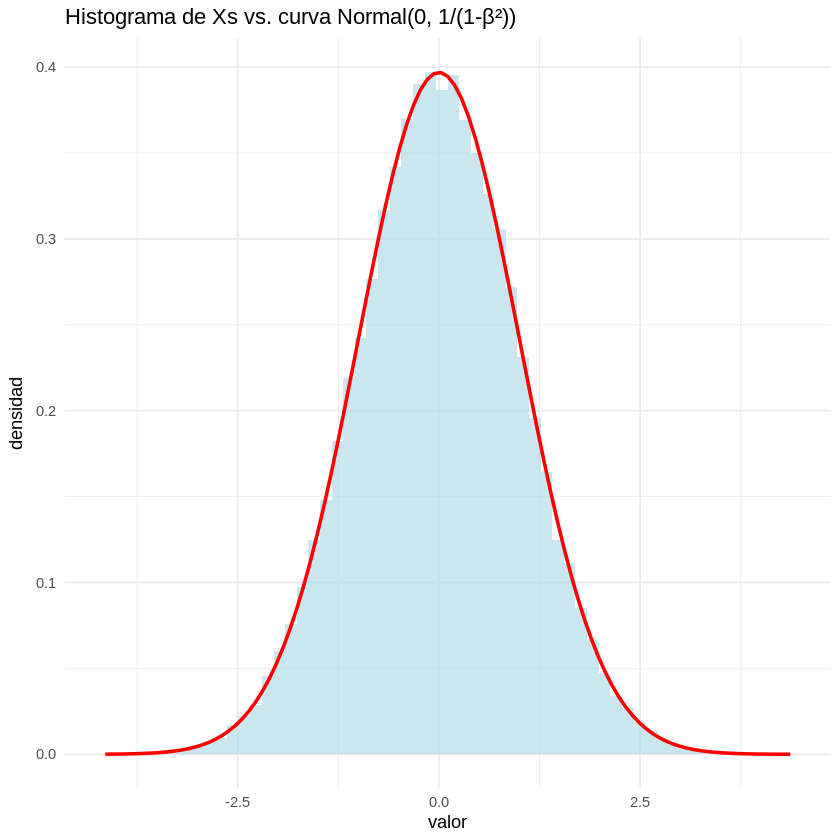

In [7]:
# ==============================================================================
# Crear histograma con curva teórica superpuesta
p1 <- ggplot(data.frame(x = Xs), aes(x = x)) +
  geom_histogram(aes(y = after_stat(density)), bins = 60, alpha = 0.65, fill = "lightblue") +
  stat_function(fun = dnorm, args = list(mean = 0, sd = desv_teorica),
                color = "red", size = 1) +
  labs(title = "Histograma de Xs vs. curva Normal(0, 1/(1-β²))",
       x = "valor", y = "densidad") +
  theme_minimal()

print(p1)

cat("\n=== LECTURA ESPERADA ===\n")
cat("* La media muestral debe ser cercana a 0.\n")
cat("* La varianza muestral debe ser cercana a 1/(1-β²) = 1/0.99 ≈ 1.0101\n")
cat("* La correlación con el valor anterior debe ser cercana a β = 0.1\n")
cat("  esto indica que X_t se parece a X_{t-1}\n")


=== LECTURA ESPERADA ===
El histograma debe parecerse a una 'campana' centrada en 0;
la curva teórica dibujada encima debería ajustar bien.
En el QQ-plot, los puntos deberían alinearse con la recta de referencia
(lo que sugiere forma normal).


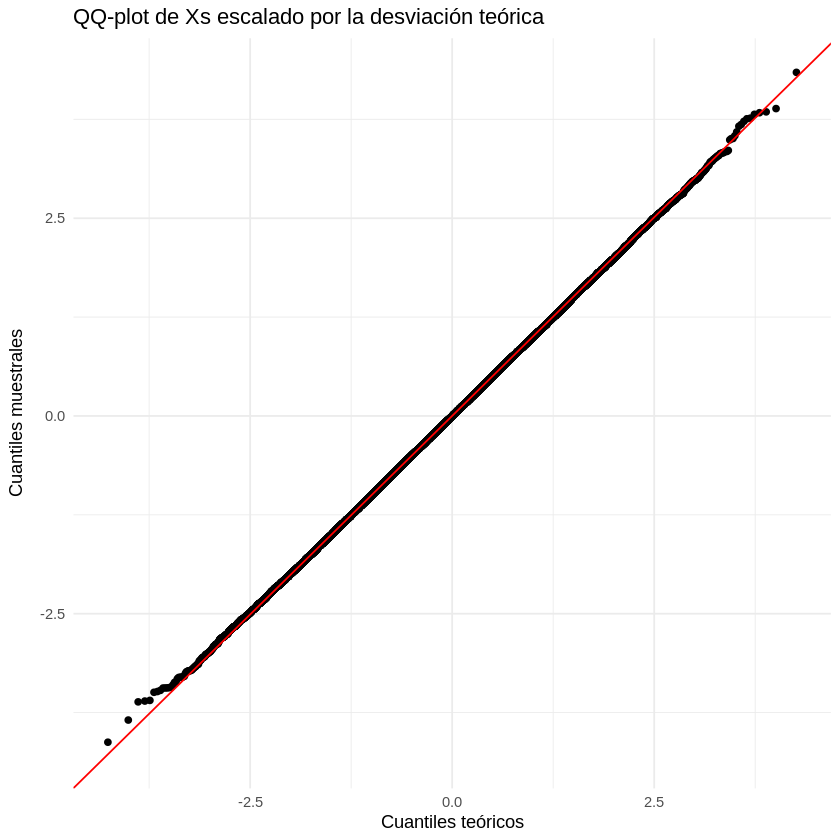

In [8]:
# Para ajustar a media y varianza teóricas, estandarizar
Z <- Xs / desv_teorica  # si la teoría es correcta, Z debería verse ~Normal(0,1)

# Crear QQ-plot
p2 <- ggplot(data.frame(sample = Z), aes(sample = sample)) +
  stat_qq() +
  stat_qq_line(color = "red") +
  labs(title = "QQ-plot de Xs escalado por la desviación teórica",
       x = "Cuantiles teóricos", y = "Cuantiles muestrales") +
  theme_minimal()

print(p2)

cat("\n=== LECTURA ESPERADA ===\n")
cat("El histograma debe parecerse a una 'campana' centrada en 0;\n")
cat("la curva teórica dibujada encima debería ajustar bien.\n")
cat("En el QQ-plot, los puntos deberían alinearse con la recta de referencia\n")
cat("(lo que sugiere forma normal).\n")


=== AUTOCORRELACIONES ===
Autocorrelaciones (lags 0..10): 1 0.097 0.009 -0.001 0.002 -0.005 0 -0.015 -0.006 -0.006 -0.001 

=== LECTURA ESPERADA ===
El valor en lag 1 cerca de 0.1, y lags mayores rápidamente más pequeños.


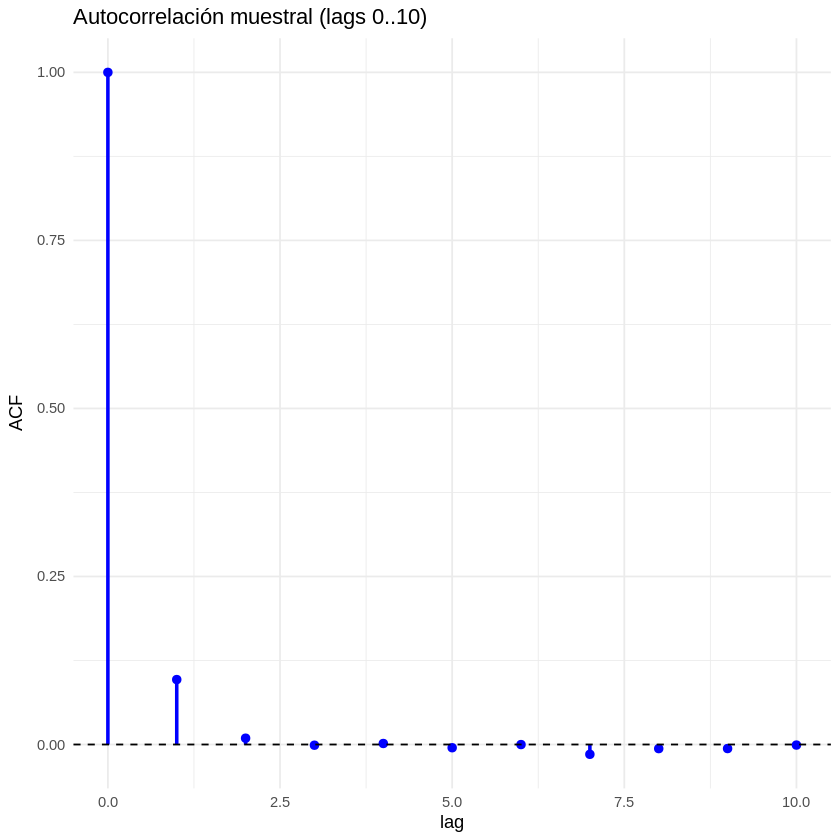

In [9]:
# Calcular autocorrelaciones hasta lag 10
acf_result <- acf(Xs, lag.max = 10, plot = FALSE)
acf_vals <- as.numeric(acf_result$acf)

cat("\n=== AUTOCORRELACIONES ===\n")
cat("Autocorrelaciones (lags 0..10):", round(acf_vals, 3), "\n")

# Crear gráfico de autocorrelación
lag_data <- data.frame(lag = 0:10, acf = acf_vals)
p3 <- ggplot(lag_data, aes(x = lag, y = acf)) +
  geom_segment(aes(xend = lag, yend = 0), color = "blue", size = 1) +
  geom_point(color = "blue", size = 2) +
  labs(title = "Autocorrelación muestral (lags 0..10)",
       x = "lag", y = "ACF") +
  theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed")

print(p3)

cat("\n=== LECTURA ESPERADA ===\n")
cat("El valor en lag 1 cerca de 0.1, y lags mayores rápidamente más pequeños.\n")

In [10]:
# Shapiro-Wilk en una submuestra (la prueba no está pensada para decenas de miles de datos)
submuestra <- Xs[1:5000]
sw_test <- shapiro.test(submuestra)

cat("\n=== TESTS DE NORMALIDAD ===\n")
cat(sprintf("Shapiro-Wilk p-valor (submuestra 5000): %8.4f\n", sw_test$p.value))

# Kolmogorov-Smirnov contra Normal con media=0 y desviación teórica
ks_test <- ks.test(Xs, "pnorm", mean = 0, sd = desv_teorica)
cat(sprintf("KS p-valor contra N(0, desv_teorica):   %8.4f\n", ks_test$p.value))

# Test de Anderson-Darling (alternativo)
ad_test <- ad.test(Xs)
cat(sprintf("Anderson-Darling p-valor:               %8.4f\n", ad_test$p.value))

cat("\n=== LECTURA ESPERADA ===\n")
cat("P-valores 'no muy pequeños' suelen ser compatibles con la normalidad teórica.\n")
cat("(Si salieran bajos, revisar tamaño de muestra, escalado y gráficos;\n")
cat("a tamaños enormes, pequeñas desviaciones pueden detectarse aunque\n")
cat("no sean relevantes en práctica).\n")


=== TESTS DE NORMALIDAD ===
Shapiro-Wilk p-valor (submuestra 5000):   0.3396
KS p-valor contra N(0, desv_teorica):     0.9535
Anderson-Darling p-valor:                 0.8627

=== LECTURA ESPERADA ===
P-valores 'no muy pequeños' suelen ser compatibles con la normalidad teórica.
(Si salieran bajos, revisar tamaño de muestra, escalado y gráficos;
a tamaños enormes, pequeñas desviaciones pueden detectarse aunque
no sean relevantes en práctica).



=== RESUMEN FINAL ===
La simulación muestra que:
1. La cadena de Markov X_t = β*X_{t-1} + ε_t converge a una distribución estacionaria
2. Esta distribución es aproximadamente Normal(0, 1/(1-β²))
3. Los valores teóricos coinciden bien con los muestrales
4. Los tests estadísticos confirman la normalidad
5. La autocorrelación muestra la dependencia temporal esperada

¡Análisis completado exitosamente!


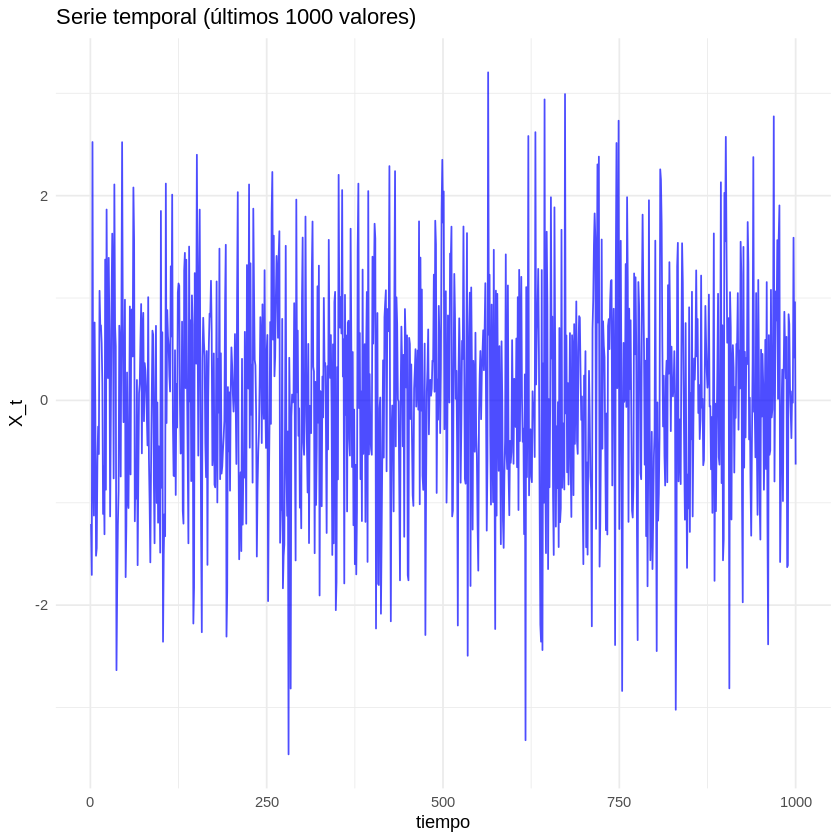

In [ ]:
cat("\n=== RESUMEN FINAL ===\n")
cat("La simulación muestra que:\n")
cat("1. La cadena de Markov X_t = β*X_{t-1} + ε_t converge a una distribución estacionaria\n")
cat("2. Esta distribución es aproximadamente Normal(0, 1/(1-β²))\n")
cat("3. Los valores teóricos coinciden bien con los muestrales\n")
cat("4. Los tests estadísticos confirman la normalidad\n")
cat("5. La autocorrelación muestra la dependencia temporal esperada\n")

# Crear gráfico de la serie temporal (últimos 1000 valores)
ultimos <- tail(Xs, 1000)
p4 <- ggplot(data.frame(t = 1:1000, x = ultimos), aes(x = t, y = x)) +
  geom_line(color = "blue", alpha = 0.7) +
  labs(title = "Evolución de la cadena de Markov (últimos 1000 valores)",
       x = "tiempo t", y = "X_t") +
  theme_minimal()

print(p4)

cat("\n¡Análisis completado exitosamente!\n")